In [1]:
import sys
from pathlib import Path

# Add the root project folder to the python path in order to use the packages
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm
from importlib import reload

import reservoirpy
reservoirpy.verbosity(0)

# SEED
SEED = 49387

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Reservoir functions

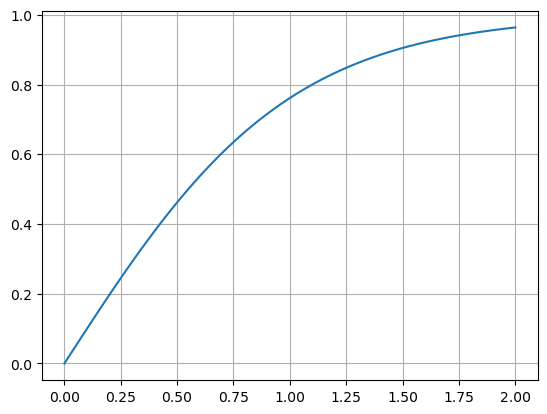

In [3]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Prediction ahead

### Mackey-Glass


In [ ]:
from reservoirpy.datasets import mackey_glass

timesteps = 15000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

# Define the time step of your Mackey-Glass system
dt = 0.00001

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

is_multivariate = False
step_ahead = 5

X_pretrain = mg_inputs[:5000]

X_train = mg_inputs[5000:10000-step_ahead]
Y_train = mg_inputs[5000+step_ahead:10000]

X_test = mg_inputs[10000-step_ahead:15000-step_ahead-step_ahead]
Y_test = mg_inputs[10000:15000-step_ahead]


plt.figure(figsize=(16,5))
plt.plot(range(500), X_test[:500])
plt.plot(range(500), Y_test[:500])
plt.show()

## Classification

### Japanese voyels

In [4]:
from reservoirpy.datasets import japanese_vowels

X_train_band, Y_train, X_test_band, Y_test = japanese_vowels()

is_multivariate = True

# Sampling rate : 10 kHz
# Source : https://archive.ics.uci.edu/dataset/128/japanese+vowels
sampling_rate = 10000

# pretrain is the same as train
X_pretrain_band = np.concatenate(X_train_band, axis=0).T

Y_train = np.squeeze(np.array(Y_train), axis=1)
Y_test = np.squeeze(np.array(Y_test), axis=1)
Y_train.shape

(270, 9)

### InsectWingbeat

### MELD

https://github.com/declare-lab/MELD


### Free Spoken Digits Dataset

In [ ]:
from datasets.load_datasets import load_FSDD_dataset

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset
sampling_rate, X_train, X_test, Y_train, Y_test = load_FSDD_dataset(data_dir, seed=SEED, visualize=True)
# Check the shapes of the datasets
print(f'X_train: ({len(X_train)}, {len(X_train[0])})')
print("Y_train:", Y_train.shape)
print(f'X_test: ({len(X_test)}, {len(X_test[0])})')
print("Y_test:", Y_test.shape)

#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)
print("X_pretrain shape:", X_pretrain.shape)

is_multivariate = False

## Multivariate generation if necessary

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

### Spectral density and peak selection

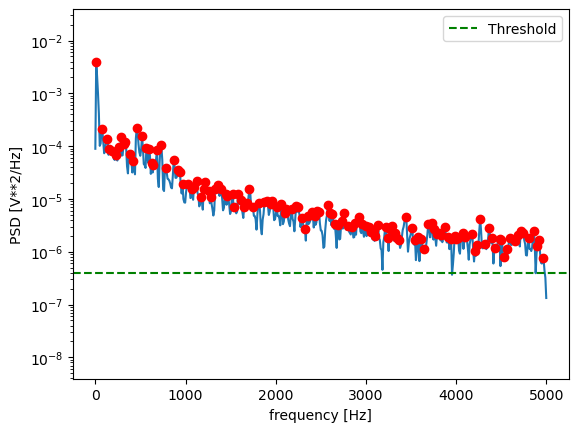

Filtered peak frequencies:  [   9.765625   68.359375  126.953125  156.25      185.546875  224.609375
  263.671875  283.203125  312.5       332.03125   380.859375  419.921875
  458.984375  517.578125  566.40625   595.703125  625.        644.53125
  683.59375   722.65625   781.25      869.140625  917.96875   937.5
  966.796875 1025.390625 1074.21875  1093.75     1123.046875 1171.875
 1201.171875 1220.703125 1259.765625 1279.296875 1328.125    1357.421875
 1396.484375 1445.3125   1464.84375  1523.4375   1542.96875  1582.03125
 1611.328125 1650.390625 1679.6875   1708.984375 1748.046875 1816.40625
 1875.       1904.296875 1943.359375 1962.890625 2011.71875  2060.546875
 2099.609375 2119.140625 2177.734375 2226.5625   2246.09375  2294.921875
 2324.21875  2353.515625 2402.34375  2431.640625 2460.9375   2480.46875
 2578.125    2607.421875 2626.953125 2656.25     2695.3125   2734.375
 2753.90625  2802.734375 2841.796875 2880.859375 2919.921875 2958.984375
 2998.046875 3037.109375 3056.640625 3

In [5]:
from datasets.multivariate_generation import extract_peak_frequencies

if is_multivariate:
    filtered_peak_freqs = extract_peak_frequencies(X_pretrain_band[0].flatten(), sampling_rate, threshold=1e-4, nperseg=1024, visualize=True)
else:
    filtered_peak_freqs = extract_peak_frequencies(X_pretrain.flatten(), sampling_rate, threshold=1e-4, nperseg=1024, visualize=True)

print("Number of frequencies selected :", len(filtered_peak_freqs))

### Applying normal band pass filter on data

In [6]:
import datasets.multivariate_generation 
reload(datasets.multivariate_generation)
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

if not is_multivariate:
    X_pretrain_band, X_train_band, X_test_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_pretrain, X_train, X_test, sampling_rate, nb_jobs=-1
    )

### Standardizing the amplitudes

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# pretrain
# Be really carefull of the column order here !
filtered_data = scaler.fit_transform(X_pretrain_band.T)
filtered_data = filtered_data.T

if not is_multivariate:

    if len(X_train[0].shape)>1:
        # train
        X_train_band = [
            np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() 
                      for time_serie in x]) for x in tqdm(X_train_band)
        ]
    
        # test
        X_test_band = [
            np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() 
                      for time_serie in x]) for x in tqdm(X_test_band)
        ]
    else: 
        # train
        X_train_band = np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in X_train_band])
    
        # test
        X_test_band = np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in X_test_band])
        

# Generating reservoirs

## Plot  pretrain dataset

In [8]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]
max_window_size = sampling_rate/filtered_peak_freqs[0]

print(min_window_size)
print(max_window_size)

2.015748031496063
1024.0


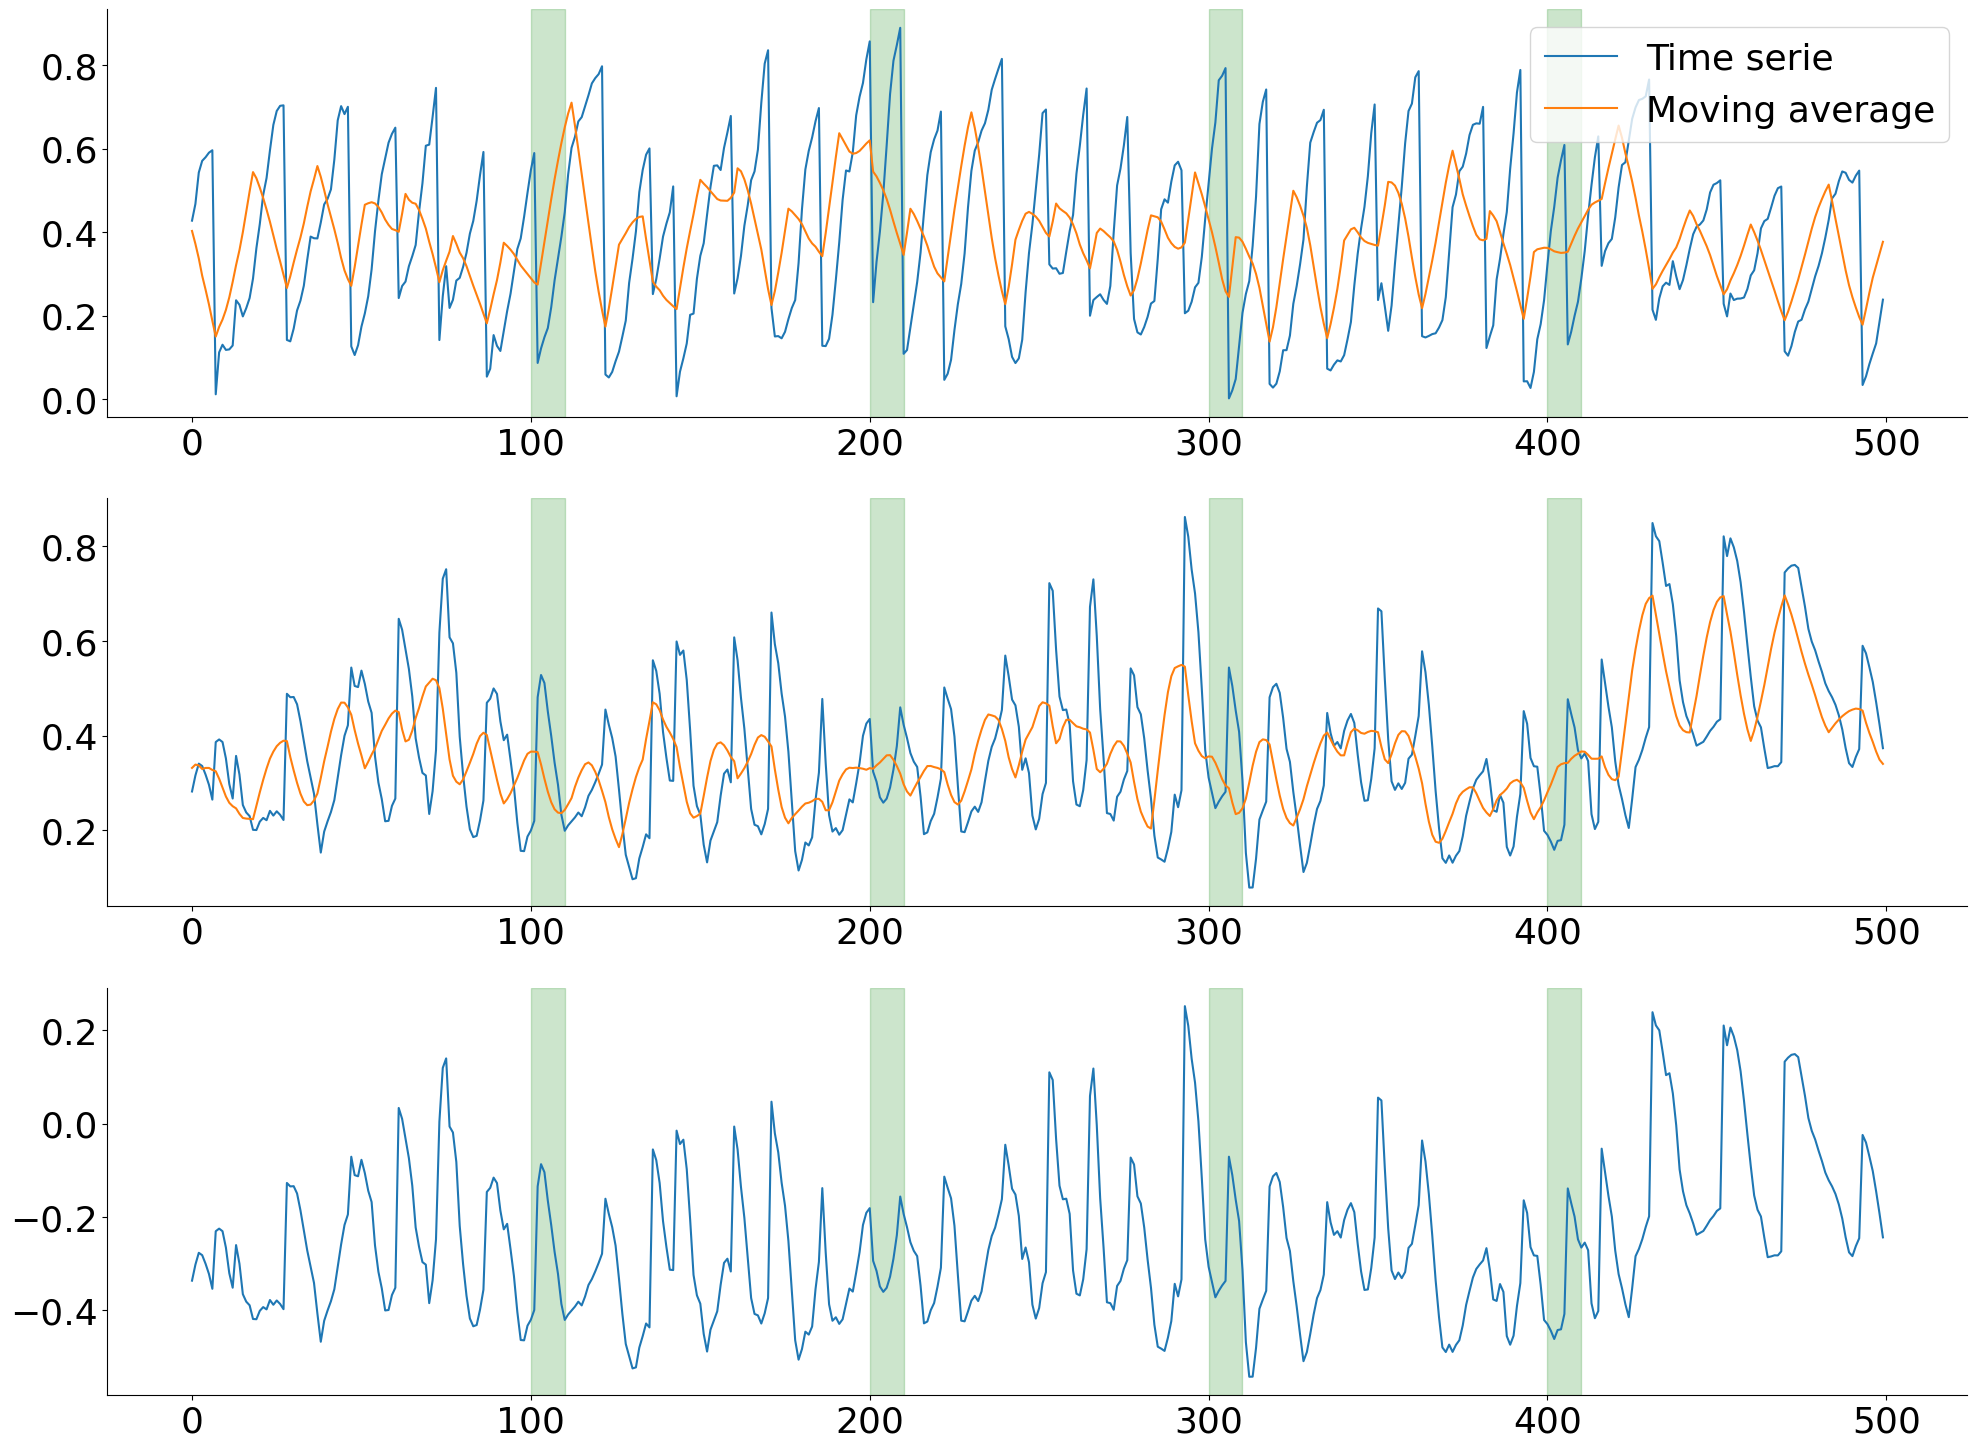

In [9]:
#Compute the moving average 
window_size = 10

if max_window_size <= window_size or  window_size <= min_window_size:
    raise ValueError(f"window_size must be greater than {min_window_size} and smaller than {max_window_size}. Current window_size is {window_size}.")

weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(3, 1, figsize=(24,18))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
ax[0].legend(fontsize=26)

NB_2 = 8
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

#Check that the scaler did a good job
ax[2].plot(range(500), X_pretrain_band[NB_2, 1000:1500], label='Time serie')

for i, ax in enumerate(ax):
    # Format subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=26)
    # draw vertical lines to represent the window for some points
    for x in range(100, 500, 100):
        ax.axvspan(x, x + window_size, color='g', alpha=0.2)

plt.show()

## Data to feed to the reservoir

Here we calculate 
**common_dimension** : the number of different dimensions in the input data
 **K** : the number of euron that will receive a particular time serie as input 
**n** : the dimension of the reservoir 

n = K * common_dimension

In [10]:
import math 

def find_common_dimension(arrays):
    common_dimension_size = None
    common_dimension_index = None

    for i in range(len(arrays[0].shape)):  # Loop over dimensions of the first dimension
        size = arrays[0].shape[i]
        if all(arr.shape[i] == size for arr in arrays[1:]):  # Check if all other arrays have the same size in this dimension
            common_dimension_size = size
            common_dimension_index = i
            break  # Exit the loop once the common dimension is found
  
    return common_dimension_index, common_dimension_size

if len(X_train_band[0].shape) > 1:
    common_xtrain_index, common_xtrain_size = find_common_dimension(X_train_band)
else:
    common_xtrain_size = X_train_band.shape[0]
    common_xtrain_index = 0        
          

print("Common dimension index is :", common_xtrain_index)
print("Number of different time series is :", common_xtrain_size)
if len(X_train_band[0].shape) > 1:
    print("Check it ! First array ", X_train_band[0].shape, " and second array", X_train_band[1].shape)

# We want the size of the reservoir to be at least 200
K = math.ceil(200 / common_xtrain_size)
n = common_xtrain_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)


Common dimension index is : 1
Number of different time series is : 12
Check it ! First array  (20, 12)  and second array (26, 12)
Dimension of our reservoir : 204
Copy of each time serie : 17


In [11]:
from connexion_generation.utility import TwoDimArrayWrapper

# We create an array of the same shape as X_pretrain_band but with the same time serie repeated K times
frequency_bands = np.repeat(filtered_data, K, axis=0)
     
frequency_bands = TwoDimArrayWrapper(frequency_bands)
frequency_bands.shape

(204, 4274)

## Construct matrices

### Shared parameters

In [12]:
INCREMENT = int(min_window_size+1)
MAX_INCREMENT = INCREMENT*10
VALUE = 0.05
target_rate = 0.7
growth_parameter = 0.15

bias_scaling = 1
input_scaling = 0.15
leaky_rate = 1

if max_window_size <= INCREMENT or  INCREMENT <= min_window_size:
    raise ValueError(f"INCREMENT must be greater than {min_window_size} and smaller than {max_window_size}. Current INCREMENT is {INCREMENT}.")


### Function to initialise and generate reservoir

In [13]:
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import run_HADSP_algorithm
import connexion_generation.bounded_adsp
reload(connexion_generation.bounded_adsp)
input_connectivity = 1
connectivity = 0

def initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, seed, training_set, visualize=False):
    Win, W, bias = init_matrices(n, input_connectivity, connectivity, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling
        
    W = run_HADSP_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, INCREMENT, VALUE,
                            target_rate, growth_parameter, max_increment=MAX_INCREMENT, visualize=visualize)
    
    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    
    return Win, W, bias, connectivity, sr


### Multivariate matrices

100%|██████████████████████████████████████████████████████████████████▋| 4239/4259 [00:01<00:00, 2651.35it/s]


<Axes: >

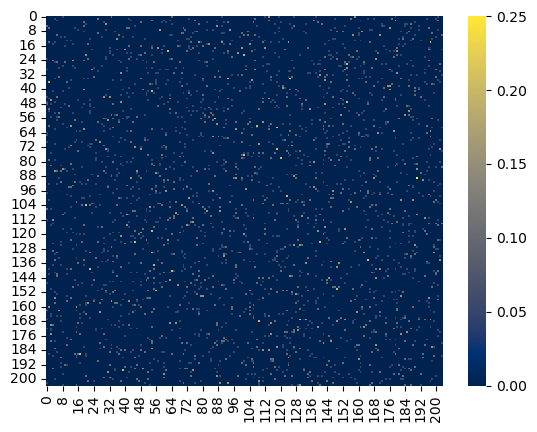

In [14]:
# HADSP + multi
Win_hadsp_multi, W_hadsp_multi, bias_hadsp_multi, connectivity_band, sr_hadsp_multi = initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, SEED, frequency_bands)

# 3rd (random + multi)
Win_random_multi, W_random_multi, bias_random_multi =  init_matrices(n, 1, connectivity_band, sr_hadsp_multi)
bias_random_multi= bias_random_multi*bias_scaling
Win_random_multi= Win_random_multi*input_scaling

eigen_random_multi = sparse.linalg.eigs(W_random_multi, k=1, which="LM", maxiter=W_random_multi.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_random_multi = max(abs(eigen_random_multi))

heatmap(W_hadsp_multi.todense(), cmap=color_palette("cividis", as_cmap=True))

### Univariate matrices

In [15]:
if not is_multivariate:
    # HADSP + uni
    Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni, connectivity_hadsp_uni, sr_hadsp_uni = initialise_and_train(input_scaling, n,  input_connectivity, connectivity, bias_scaling, SEED, X_pretrain.flatten())
    
    # random + uni
    Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
    bias_normal= bias_normal*bias_scaling
    Win_normal= Win_normal*input_scaling   
    
    eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_normal = max(abs(eigen_normal))
    
    heatmap(W_hadsp_uni.todense(), cmap=color_palette("cividis", as_cmap=True))


### Spectral radius normalisation

In [16]:
print(sr_hadsp_multi)
print(sr_random_multi)
if not is_multivariate:
    print(sr_normal)
    print(sr_hadsp_uni)

0.9010520862004728
0.9010520861959405


In [17]:
# Spectral radius normalisation
normal_sr = 0.99
W_hadsp_multi = W_hadsp_multi/sr_hadsp_multi*normal_sr
W_random_multi = W_random_multi/sr_random_multi*normal_sr
if not is_multivariate:
    W_normal = W_normal/sr_normal*normal_sr
    W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr

# Performance

In [18]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

N_JOBS = -1
RIDGE_COEF = 1e-7

## Classification

### Classification for multivariate

In [19]:
# We give Xtrain_band and Xtest_band the same shape as the expected input of the reservoir
caca = []
caca_test = []
for i in tqdm(range(len(X_train_band))):
    if common_xtrain_index == 1:
        caca.append(np.repeat(X_train_band[i], K, axis=1))
    else:
        caca.append(np.repeat(X_train_band[i], K, axis=0).T) # correct axis depends on X_train_band shape
for i in tqdm(range(len(X_test_band))):
    if common_xtrain_index == 1:
        caca_test.append(np.repeat(X_test_band[i], K, axis=1))
    else:
        caca_test.append(np.repeat(X_test_band[i], K, axis=0).T)

print("caca example shape :", caca[1].shape)     
print("We should have :", caca[0].shape[1], "==", n)

100%|████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 53808.55it/s]

caca example shape : (26, 204)
We should have : 204 == 204


In [20]:
from performances.esn_model_evaluation import train_and_predict_model, compute_score
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

Y_pred_hadsp_multi = train_and_predict_model(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, activation_function, RIDGE_COEF, caca, caca_test, Y_train, N_JOBS)

Y_pred_random_multi = train_and_predict_model(W_random_multi, Win_random_multi, bias_random_multi, activation_function, RIDGE_COEF, caca, caca_test, Y_train, N_JOBS)


Running Reservoir-0: 100%|██████████| 14/14 [00:00<00:00, 11855.49it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]

Running Reservoir-0: 100%|██████████| 14/14 [00:00<00:00, 9377.24it/s]

Running Reservoir-0: 100%|██████████| 17/17 [00:00<00:00, 30367.62it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]9it/s]

Running Reservoir-0: 100%|██████████| 16/16 [00:00<00:00, 10438.46it/s]

Running Reservoir-0: 100%|██████████| 16/16 [00:00<00:00, 9324.56it/s]]

Running Reservoir-0: 100%|██████████| 16/16 [00:00<00:00, 11237.25it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]


Running Reservoir-0:   0%|          | 0/17 [00:00<?, ?it/s]it/s]]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 7869.24it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 39945.75it/s]

Running Reservoir-0: 100%|██████████| 18/18 [00:00<00:00, 17958.49it/s]

Running Reservo

In [21]:
score = compute_score(Y_pred_hadsp_multi, Y_test, "HADSP multi")

score = compute_score(Y_pred_random_multi, Y_test, "random multi")

Accuracy for HADSP multi: 96.757 %
Accuracy for random multi: 95.946 %


### Classification for univariate

In [22]:
if not is_multivariate: 
    # Create a list to store the arrays with the same shape as the expected input of the reservoir
    pipi = []
    pipi_test = []
    
    for i in tqdm(range(len(X_train))):
        pipi.append(np.repeat(X_train[i], n, axis=1))

    for i in tqdm(range(len(X_test))):
        pipi_test.append(np.repeat(X_test[i], n, axis=1))

    print("pipi example shape :", pipi[0].shape)     
    print("We should have :", pipi[0].shape[1], "==", n)

In [23]:
if not is_multivariate:
    Y_pred_hadsp_uni = train_and_predict_model(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, RIDGE_COEF, pipi, pipi_test, Y_train, N_JOBS)
    
    Y_pred_normal = train_and_predict_model(W_normal, Win_normal, bias_normal, activation_function, RIDGE_COEF, pipi, pipi_test, Y_train, N_JOBS)

In [24]:
if not is_multivariate:
    score = compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni")

    score = compute_score(Y_pred_normal, Y_test, "random uni")

## Prediction ahead

### Training

In [ ]:
caca = np.repeat(np.squeeze(np.array(X_train_band)), K, axis=0)
caca_test = np.repeat(np.squeeze(np.array(X_test_band)), K, axis=0)

print("Step ahead : ", step_ahead)

In [ ]:
caca.shape

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train
reload(reservoir.reservoir)

# To remember
np.zeros(2000)

# to generate the evaluation dataset

# Training random + MG
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, X_train, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training for HADSP + MG
Wout_hadsp_uni, b_out_hadsp_uni, last_state_hadsp_uni = train(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, X_train, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training random + bandfilter
Wout_random_multi, b_out_random_multi, last_state_random_multi = train(W_random_multi, Win_random_multi, bias_random_multi, caca, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training output HASDP + bandfilter
Wout_hadsp_multi, b_out_hadsp_multi, last_state_hadsp_multi = train(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, caca, Y_train, activation_function, ridge_coef = RIDGE_COEF)

### Prediction

In [ ]:
from reservoir.reservoir import run
from reservoir.reservoirpy_util import plot_results, plot_readout

# Prediction for random + MG
y_pred_random_uni = run(W_normal, Win_normal, bias_normal, Wout_normal, X_test, activation_function, b_out_normal, last_state_normal)

# Prediction for HADSP + MG
y_pred_hadsp_uni = run(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, Wout_hadsp_uni, X_test, activation_function, b_out_hadsp_uni, last_state_hadsp_uni)

# Prediction for random + bandfilter
y_pred_random_multi = run(W_random_multi, Win_random_multi, bias_random_multi, Wout_random_multi, caca_test, activation_function, b_out_random_multi, last_state_random_multi)

# Prediction for HADSP + bandfilter
y_pred_hadsp_multi = run(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, Wout_hadsp_multi, caca_test, activation_function, b_out_hadsp_multi, last_state_hadsp_multi)


plot_results(y_pred_random_multi, Y_test, sample=400)


In [ ]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

print("nrmse normal        :", float(nrmse(Y_test[:300], y_pred_random_uni[:300])))
print("nrmse hadsp     :", float(nrmse(Y_test[:300], y_pred_hadsp_uni[:300])))
print("nrmse random + band :", float(nrmse(Y_test[:300], y_pred_random_multi[:300])))
print("nrmse hadsp + band   :", float(nrmse(Y_test[:300], y_pred_hadsp_multi[:300])))

In [ ]:
nrmse_array_random_uni = []
nrmse_array_hadsp_uni = []
nrmse_array_random_multi = []
nrmse_array_hadsp_multi = []

for i in range(len(Y_test)-100- step_ahead):
    Y_test_i = Y_test[i:100+i]
    nrmse_array_random_uni.append(nrmse(Y_test_i, y_pred_random_uni[i:100+i]))
    nrmse_array_hadsp_uni.append(nrmse(Y_test_i, y_pred_hadsp_uni[i:100+i]))
    nrmse_array_random_multi.append(nrmse(Y_test_i, y_pred_random_multi[i:100+i]))
    nrmse_array_hadsp_multi.append(nrmse(Y_test_i, y_pred_hadsp_multi[i:100+i]))
    
log10_nrmse_random_uni= np.log10(nrmse_array_random_uni)
log10_nrmse_hadsp_uni = np.log10(nrmse_array_hadsp_uni)
log10_nrmse_random_multi = np.log10(nrmse_array_random_multi)
log10_nrmse_hadsp_multi = np.log10(nrmse_array_hadsp_multi)
plt.figure()
plt.plot(log10_nrmse_random_uni[:1000])
plt.plot(log10_nrmse_hadsp_uni[:1000])
plt.plot(log10_nrmse_random_multi[:1000])
plt.plot(log10_nrmse_hadsp_multi[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

# Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
# Be really carefull of the column order here !
df_data = scaler.fit_transform(X_pretrain_band.T)
df_data = df_data.T
df = pd.DataFrame(df_data.T)
# Initialize a progress bar for total number of series
progress_bar = tqdm(total=df.shape[1]**2, position=0, leave=True)

# Initialize an empty correlation matrix
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation for each pair of series
for col1 in df.columns:
    progress_bar.set_description(f"Processing {col1}")
    for col2 in df.columns:
        correlation_matrix.loc[col1, col2] = df[col1].corr(df[col2], method='pearson', min_periods=5)

        progress_bar.update(1)  # Update the progress bar after processing each series
    
progress_bar.close()

# Convert correlation_matrix to numeric as it is stored as objects due to tqdm
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Perform hierarchical clustering
linked = linkage(correlation_matrix, 'single')

# Get the order of rows/columns after hierarchical clustering
row_order = leaves_list(linked)

# Reorder the correlation matrix
sorted_corr_matrix = correlation_matrix.iloc[row_order, :].iloc[:, row_order]

# Visualize the sorted correlation matrix with a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='vlag', vmin=-1, vmax=1)
plt.title('Clustered Pairwise Correlation of Time Series')
plt.show()


In [ ]:
from scipy.sparse import coo_matrix

row_order_r = np.array([i + k for i in row_order*K for k in range(K)])

# Convert the sparse matrix to a dense format (if memory allows)
dense_matrix = W_hadsp_multi.toarray()

# Reorder the dense matrix using the repeated ordering
reordered_matrix = dense_matrix[np.ix_(row_order_r, row_order_r)]

# Convert the reordered dense matrix back to a sparse format if needed
sparse_reordered_matrix = coo_matrix(reordered_matrix)

In [ ]:
heatmap(sparse_reordered_matrix.todense(), cmap=color_palette("vlag", as_cmap=True))

## Motifs

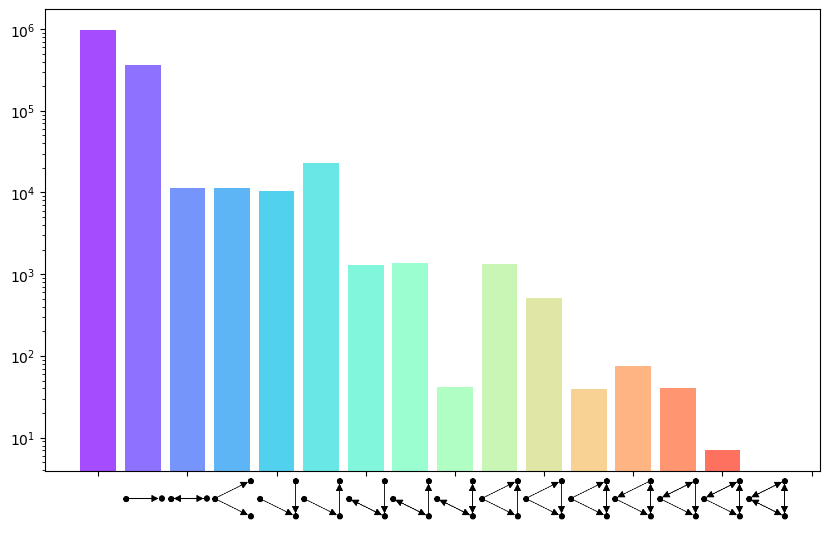

In [47]:
import numpy as np

import analysis.topology
reload(analysis.topology)
from analysis.topology import motif_distribution, draw_motifs_distribution

motifs_count = motif_distribution(W_hadsp_multi.A)
draw_motifs_distribution(motifs_count)